#**Models evaluation**

---

In this notebook, we analyze the training progress and performance of models trained in model_training.ipynb. The evaluated models include:
* U-Net
* FCN with ResNet-50 backbone
* FCN with pretrained ResNet-50 backbone
* DeepLabV3 with MobileNetV3-Large backbone
* DeepLabV3 with pretrained MobileNetV3-Large backbone

The evaluation process covers two main aspects:
* **Training Analysis** – visualizing and comparing training and validation loss curves.
* **Performance** Comparison – comparing:
    * **Training time** (focus on relative differences rather than the absolute numbers).
    * **Dice Score** – a segmentation accuracy metric ranging from 0 to 1, measuring the overlap between the predicted mask and the ground truth mask. A Dice Score of 1 means perfect overlap, while 0 means no overlap. **The higher the Dice Score, the better the segmentation performance**.
    * **HD95** (95th percentile Hausdorff Distance) – measures the maximum surface distance between two segmentation boundaries, but considers the 95th percentile to reduce sensitivity to outliers. **Lower HD95 values indicate better shape alignment between prediction and ground truth.**

Through this evaluation, we aim to identify not only which models achieve the best segmentation performance but also which offer the most favorable trade-off between accuracy and computational efficiency.



 **Importing Libraries and Modules**

 ---

 In this starting section, we import all required libraries and modules for model evaluation:
 * `matplotlib.pyplot` and `seaborn` - visualization tools for plotting bar charts, loss curves, and other performance graphs,
 * `torch` and `torch.nn` -  core PyTorch functionality for tensor operations, neural network layers, and model handling,
 * `os` -  file path handling and directory operations,
 * `json` – reading and parsing the saved test dataset file names from JSON format,
 * `torchvision.models` & pre-defined weights (FCN_ResNet50_Weights, DeepLabV3_MobileNet_V3_Large_Weights) – loading and initializing segmentation models with or without pretrained weights,
 * `monai.networks.nets.UNet` – MONAI’s implementation of the U-Net architecture,
 * `monai.metrics` (DiceMetric, HausdorffDistanceMetric) – evaluation metrics for segmentation quality:
 * `Dataset_loader.Dataset` – custom dataset loader module responsible for loading and preprocessing medical image data.



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import json
import os
from torch import nn
from torchvision import models
from torchvision.models.segmentation import FCN_ResNet50_Weights, DeepLabV3_MobileNet_V3_Large_Weights
from monai.networks.nets import UNet
from monai.metrics import DiceMetric, HausdorffDistanceMetric

import sys
sys.path.append('/kaggle/input/dataset-loader')
from Dataset_loader import Dataset

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-08-10 18:03:54.299049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754849034.321548     148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754849034.328492     148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading Saved Training Information

---

After importing all necessary libraries, we define a helper function `get_info_from_path()` that loads training metadata saved during the training phase. These files (saved as `.pt` using PyTorch) contain:
* list of training loss values for each epoch,
* list of validation loss values for each epoch,
* total training time in seconds.

Using this function, we load the stored training history for all evaluated models. This allows us to later plot loss curves, compare training speed, and analyze training durations for each architecture.

In [4]:
def get_info_from_path(name):
    info_path = "/kaggle/input/mri-data/Training_info"
    info_dict = tc.load(os.path.join(info_path, name))
    train_loss_lst = info_dict["train_loss_lst"]
    val_loss_lst = info_dict["val_loss_lst"]
    time = info_dict["time"]
    return train_loss_lst, val_loss_lst, time


Unet_train_losses, Unet_val_losses, Unet_time = get_info_from_path('UNet_info.pt')
FCN_train_losses, FCN_val_losses, FCN_time = get_info_from_path('FCN_info.pt')
FCN_pretrained_train_losses, FCN_pretrained_val_losses, FCN_pretrained_time = get_info_from_path('FCN_pretrained_info.pt')
Deeplabv3_train_losses, Deeplabv3_val_losses, Deeplabv3_time = get_info_from_path('DeepLabv3_info.pt')
Deeplabv3_pretrained_train_losses, Deeplabv3_pretrained_val_losses, Deeplabv3_pretrained_time = get_info_from_path('DeepLabv3_pretrained_info.pt')

To visually analyze the training process of each model, we define a helper function `plot_losses()`, which:
* Creates a subplot in a specified grid layout (rows, cols).
* Plots **training loss** (red line) and **validation loss** (blue line) over epochs.
* Adds axis labels, a title, and a grid for better readability. (Legend is displayed only for the first subplot to avoid repetition.)

We store the loss histories and training times for all models in data_tuples and then iterate through them to generate a 2×3 grid of loss curves. This visualization allows quick comparison of how fast and how stably each architecture converged during training.

**Note:** Data_tuples structure will be reused later in the notebook when comparing training times and evaluation metrics across models, ensuring consistency and avoiding code repetition.

In [5]:
def plot_losses(rows, cols, idx, title, train_losses, val_losses):
    plt.subplot(rows, cols, idx)
    plt.plot(train_losses, "r-", label="Training Loss")
    plt.plot(val_losses, "b-", label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch",)
    plt.ylabel("Loss")
    plt.grid(True)
    if idx == 1:
        plt.legend()

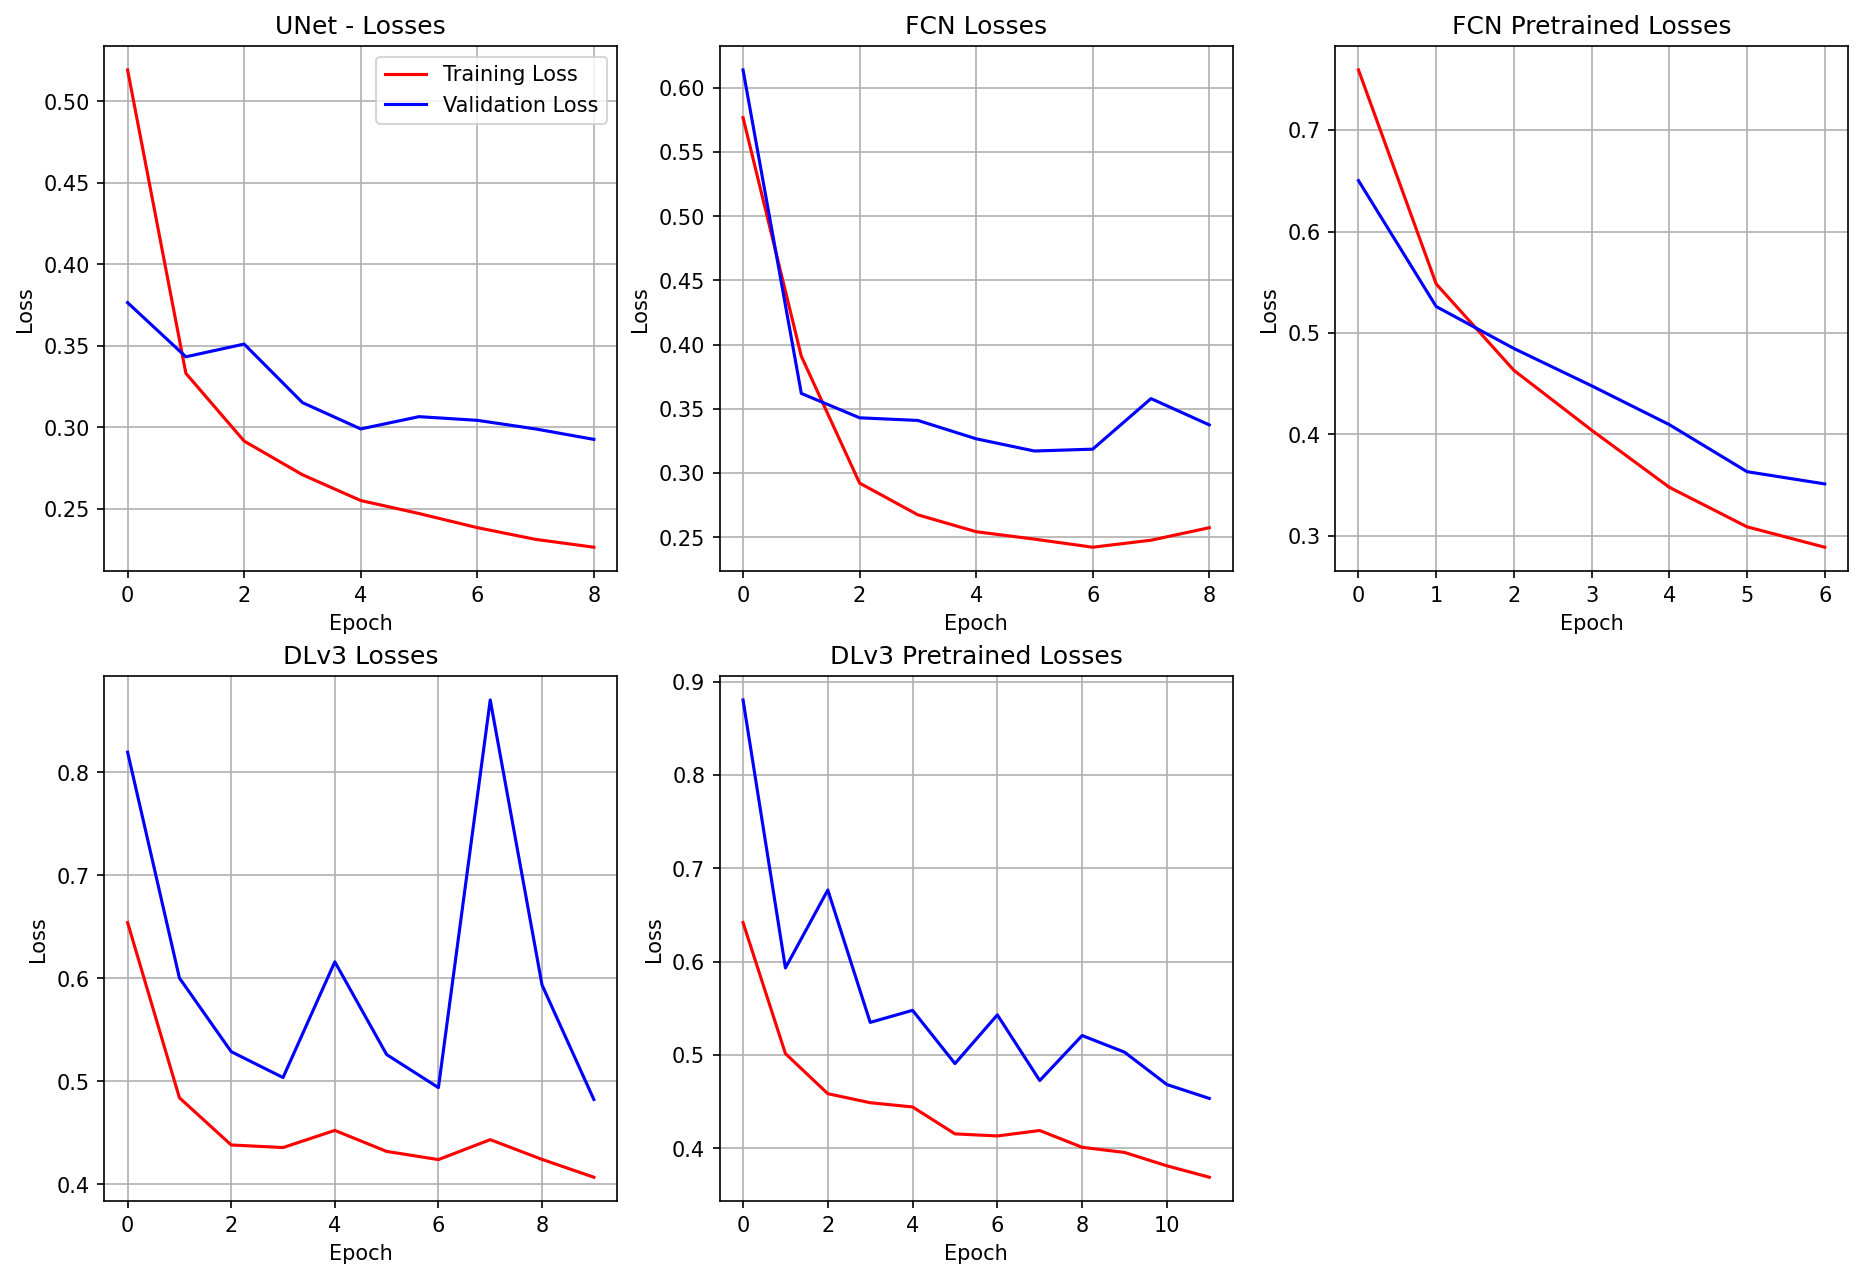

In [6]:
data_tuples = [
    ("UNet - Losses", Unet_train_losses, Unet_val_losses, Unet_time),
    ("FCN Losses", FCN_train_losses, FCN_val_losses, FCN_time),
    ("FCN Pretrained Losses", FCN_pretrained_train_losses, FCN_pretrained_val_losses, FCN_pretrained_time),
    ("DLv3 Losses", Deeplabv3_train_losses, Deeplabv3_val_losses, Deeplabv3_time),
    ("DLv3 Pretrained Losses", Deeplabv3_pretrained_train_losses, Deeplabv3_pretrained_val_losses, Deeplabv3_pretrained_time)
]

plt.figure(figsize=(15, 10), dpi=150)
for idx, tuple in enumerate(data_tuples):
    plot_losses(2, 3, idx+1, tuple[0], tuple[1], tuple[2])

plt.show()

**Loss Curves Overview**

---

The plots above illustrate the training and validation loss curves for all analyzed models. Several conclusions can be drawn:

1. **UNet**  
* Shows the most stable training behavior.  
* Both training and validation losses decrease smoothly and remain close to each other.  
* No clear signs of overfitting are visible, suggesting that UNet is well-suited for this task.  

2. **FCN with ResNet-50 backbone (without pretrained weights)**  
* Training converges quickly, with a noticeable decrease in both training and validation losses.  
* After several epochs, the validation curve starts to diverge slightly from the training one, which may indicate the beginning of overfitting.  

3. **FCN with pretrained ResNet-50 backbone**  
* The training and validation losses are smoother and more aligned compared to the non-pretrained version.  
* Pretraining on ImageNet provided some stabilization, but the improvement is not dramatic. (ImageNet features are less transferable to MRI segmentation tasks.)  

4. **DeepLabV3 with MobileNetV3-Large backbone (without pretrained weights)**  
* The least stable of all models: the validation curve oscillates heavily across epochs.  
* Indicates difficulties in model adaptation to the dataset.  
* Overall, training can be considered unsuccessful.  

5. **DeepLabV3 with pretrained MobileNetV3-Large backbone**  
* Slightly more stable than the non-pretrained version, but validation loss still fluctuates significantly.  
* Pretraining helped only marginally, and the model remains unsuitable compared to UNet and FCN.  


**Summary:**  
* **UNet** demonstrates the most stable and effective training process, confirming its suitability for medical image segmentation tasks.  
* **FCN** achieves acceptable results, but shows early signs of overfitting.  
* **DeepLabV3** struggles with stability, even when pretrained, and does not adapt well to this problem.  

Building Testing Class

---

To evaluate and compare the performance of trained models, **`TestModel` class** has been implemented, which main goal is to **organize the testing process and avoid repeating code**.  

Key features:  

* **Code reusability and organization**  
Instead of rewriting loops for inference, metric calculation, and result storage for each model, all these steps are wrapped into one unified class.  
Each trained network will have its own `TestModel` instance, which simplifies the workflow and makes comparisons more straightforward.  

* **Storing results**  
The class stores both **predictions** and **ground-truth masks**, as well as the **computed metrics** (Dice and HD95).  
This design allows us to easily compare different models without rerunning inference.  

* **Metrics**  
Integrated with **MONAI’s DiceMetric and HausdorffDistanceMetric**, ensuring consistent and reliable metric evaluation.  
Metrics are calculated with NaN/Inf filtering for stability.  

* **Model state loading**  
The method `load_model_state` allows loading pretrained weights directly from the saved checkpoint folder.  
This ensures reproducibility and lets us test different models in a unified way.  

* **Testing loop**  
The method `test_model` executes a forward pass on the test dataset (with `torch.no_grad()` for efficiency).  
If the model returns a dictionary (as in torchvision’s FCN or DeepLab), the `"out"` key is handled automatically.  

* **Multi-GPU support**  
If multiple GPUs are available (Kaggle offers dual T4), the model is wrapped in **`nn.DataParallel`**, distributing computations across devices.  

* **Convenience methods**  
`print_model_metrics()` provides a quick statistical overview (average, min, max, std) for Dice and HD95.  

In [11]:
class TestModel:
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.predictions = []
        self.mask_lst = []
        self.threshold = 0.5
        self.device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        if tc.cuda.device_count() > 1: #Kaggle offers 2xT4, we divide our computing power beetwen those two (DataParallel)
            self.model = nn.DataParallel(self.model)

        #Metrics
        self.dice_func = DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
        self.hd95_func = HausdorffDistanceMetric(include_background=True, reduction="mean", get_not_nans=True)
        self.dice_score = []
        self.hd95 = [] 
    
    def pred_loop(self, testing_loader):
        for images, masks in testing_loader:
            images = images.to(self.device)
            masks = masks.to(self.device)
            output = self.model(images.unsqueeze(1))
            if isinstance(output, dict):
                output = output["out"]
            output = tc.nn.Sigmoid()(output)
            output = (output > self.threshold).int()
            self.predictions.append(output.cpu())
            self.mask_lst.append(masks.unsqueeze(1).cpu())
        self.predictions = tc.cat(self.predictions, dim=0)
        self.mask_lst = tc.cat(self.mask_lst, dim=0)
        self.calculate_dice_score()
        self.calculate_hd95()

    def load_model_state(self, name):
        folder_path = '/kaggle/input/mri-data/Models'
        self.model.load_state_dict(tc.load(os.path.join(folder_path, name)))
    
    def test_model(self, testing_loader):
        self.model.eval()
        with tc.no_grad():
            self.pred_loop(testing_loader)
    
    def calculate_dice_score(self):
        dice_score = self.dice_func(self.predictions, self.mask_lst)
        dice_score = dice_score[~dice_score.isnan()]
        dice_score = dice_score[~dice_score.isinf()]
        self.dice_score = dice_score
    
    def calculate_hd95(self):
        hd95_score = self.hd95_func(self.predictions, self.mask_lst)
        hd95_score = hd95_score[~hd95_score.isnan()]
        hd95_score = hd95_score[~hd95_score.isinf()]
        self.hd95 = hd95_score
    
    def get_predictions(self):
        return self.predictions
    
    def get_masks(self):
        return self.mask_lst

    def print_model_metrics(self):
        print(f"\n------- {self.model_name} metrics -------")
        print(f"Average Dice score: {self.dice_score.mean():.4f}")
        print(f"Minimum Dice score: {self.dice_score.min():.4f}")
        print(f"Maximum Dice score: {self.dice_score.max():.4f}")
        print(f"Std Dice score: {self.dice_score.std():.4f}")
        print("----")
        print(f"Average HD95 score: {self.hd95.mean():.4f}")
        print(f"Minimum HD95 score: {self.hd95.min():.4f}")
        print(f"Maximum HD95 score: {self.hd95.max():.4f}")
        print(f"Std HD95 score: {self.hd95.std():.4f}")

**Loading Data and Models**

---

In this part, we prepare the test data and configure the models for evaluation:  

* **Loading data names**  
From the file `data_names_dict.txt`, we load a dictionary containing dataset split.  
Then select the part assigned to the **test set**.  

* **Dataset and preprocessing**  
For the test data, we create an instance of the `Dataset` class, which is responsible for loading the data and performing preprocessing.  

* **DataLoader**  
The DataLoader, built on top of the test dataset, allows for convenient iteration during model evaluation.  
We use **batch_size=64** and enable shuffling (`shuffle=True`) to ensure variety within mini-batches.  

* **Model preparation**  
At this stage, we **initialize the models** that will be evaluated later.  
The actual weights of the trained models will be loaded afterwards using the  
`load_model_state` method from the `TestModel` class. 

In [ ]:
with open("/kaggle/input/mri-data/Data_names/data_names_dict.txt", "r") as file:
    data_names_dict = json.load(file)

test_data_names = data_names_dict["test"]
Testing_dataset = Dataset(test_data_names)
Testing_dataset.preprocess_data()
testing_loader = tc.utils.data.DataLoader(Testing_dataset, batch_size=64, shuffle=True)

In [12]:
model_Unet = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=[16, 32, 64, 128, 256],
    strides=(2, 2, 2, 2),
    dropout=0.16454162080022391
)

model_FCN = models.segmentation.fcn_resnet50(weights=None, num_classes=1)
model_FCN.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model_FCN_pretrained = models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights)
model_FCN_pretrained.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_FCN_pretrained.classifier[4] = nn.Conv2d(512, 1, kernel_size=1) 

model_deeplabv3 = models.segmentation.deeplabv3_mobilenet_v3_large(weights=None, num_classes=1)
model_deeplabv3.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)

model_deeplabv3_pretrained = models.segmentation.deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights)
model_deeplabv3_pretrained.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model_deeplabv3_pretrained.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

After preparing the models, we proceed to load the trained weights and evaluate each model on the test dataset. The `models_dict` dictionary stores all initialized `TestModel` objects. The `files_name` list contains the corresponding filenames of the trained model weights. We iterate through both structures simultaneously:  
1. **Load weights** for each model using the `load_model_state` method.  
2. **Test** on the test dataset with the `test_model` method.  
3. **Print evaluation metrics** (Dice and HD95) using `print_model_metrics`.  

This way, all models are tested consistently on the same dataset, and their results are directly comparable.

In [13]:
models_dict = {
    "Unet": TestModel(model_Unet, "UNet"),
    "FCN": TestModel(model_FCN, "FCN"),
    "FCN pretrained": TestModel(model_FCN_pretrained, "FCN pretrained"),
    "DLv3": TestModel(model_deeplabv3, "Deeplabv3"),
    "DLv3 pretrained": TestModel(model_deeplabv3_pretrained, "Deeplabv3 pretrained")
}

files_name = [
    'UNet_trained.pth',
    'FCN_trained.pth',
    'FCN_pretrained_trained.pth',
    'DeepLabv3_trained.pth',
    'DeepLabv3_pretrained_trained.pth',
]

for i, key in enumerate(models_dict):
    models_dict[key].load_model_state(files_name[i])
    models_dict[key].test_model(testing_loader)
    models_dict[key].print_model_metrics()


------- UNet metrics -------
Average Dice score: 0.7799
Minimum Dice score: 0.0000
Maximum Dice score: 0.9831
Std Dice score: 0.1792
----
Average HD95 score: 15.0334
Minimum HD95 score: 1.0000
Maximum HD95 score: 131.0153
Std HD95 score: 19.0065

------- FCN metrics -------
Average Dice score: 0.7412
Minimum Dice score: 0.0000
Maximum Dice score: 0.9744
Std Dice score: 0.1992
----
Average HD95 score: 14.3881
Minimum HD95 score: 1.0000
Maximum HD95 score: 107.3546
Std HD95 score: 19.9854

------- FCN pretrained metrics -------
Average Dice score: 0.7456
Minimum Dice score: 0.0000
Maximum Dice score: 0.9927
Std Dice score: 0.2094
----
Average HD95 score: 12.2569
Minimum HD95 score: 1.0000
Maximum HD95 score: 160.8633
Std HD95 score: 25.0264

------- Deeplabv3 metrics -------
Average Dice score: 0.5447
Minimum Dice score: 0.0000
Maximum Dice score: 0.9500
Std Dice score: 0.2926
----
Average HD95 score: 18.7434
Minimum HD95 score: 1.0000
Maximum HD95 score: 97.0464
Std HD95 score: 23.3277

**Model performance comparision**

---

After completing the evaluation of all models on the test dataset, we proceed to visualize and compare the results.  
The comparison is based on three aspects:  
1. **Average Dice score**  
2. **Average HD95 score**  
3. **Training time**  

The first part of the code is responsible for collecting metrics into the appropriate storage lists:
* `model_names` - stores names of the models,
* `dices_lst` - stores the average Dice scores,
* `hd05_lst` - stores the average HD95 values.

In [ ]:
model_names = []
dices_lst = []
hd95_lst = []

for key in models_dict:
    model_names.append(models_dict[key].model_name)
    dices_lst.append(models_dict[key].dice_score.mean().item())
    hd95_lst.append(models_dict[key].hd95.mean().item())

model_names[3] = "DLv3" #changing name for better visibility on plot
model_names[4] = "DLv3 pretrained"

models_time_lst = [round(row[3] / 60, 2) for row in data_tuples] #changing time unit

Then after collecting all metrics we define helper function `subplot_bar` which:
* creates a bar plot with `seaborn`,
* annotates each bar with its exact numeric value,
* adjusts axis labels and titles,
* optionally rotates and shows model names only on the last plot to avoid clutter

Using mentioned helper function we generate plots containing all metrics in form of subplots bar plots.

In [74]:
def subplot_bar(ax, names, y, title, y_label, show_names=False):
    sns.barplot(x=names, y=y, palette=sns.color_palette(palette='cool'), ax=ax)
    for i, value in enumerate(y):
        ax.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_ylim(0,  max(y) * 1.2)
    if show_names:
        ax.set_xticklabels(names, rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


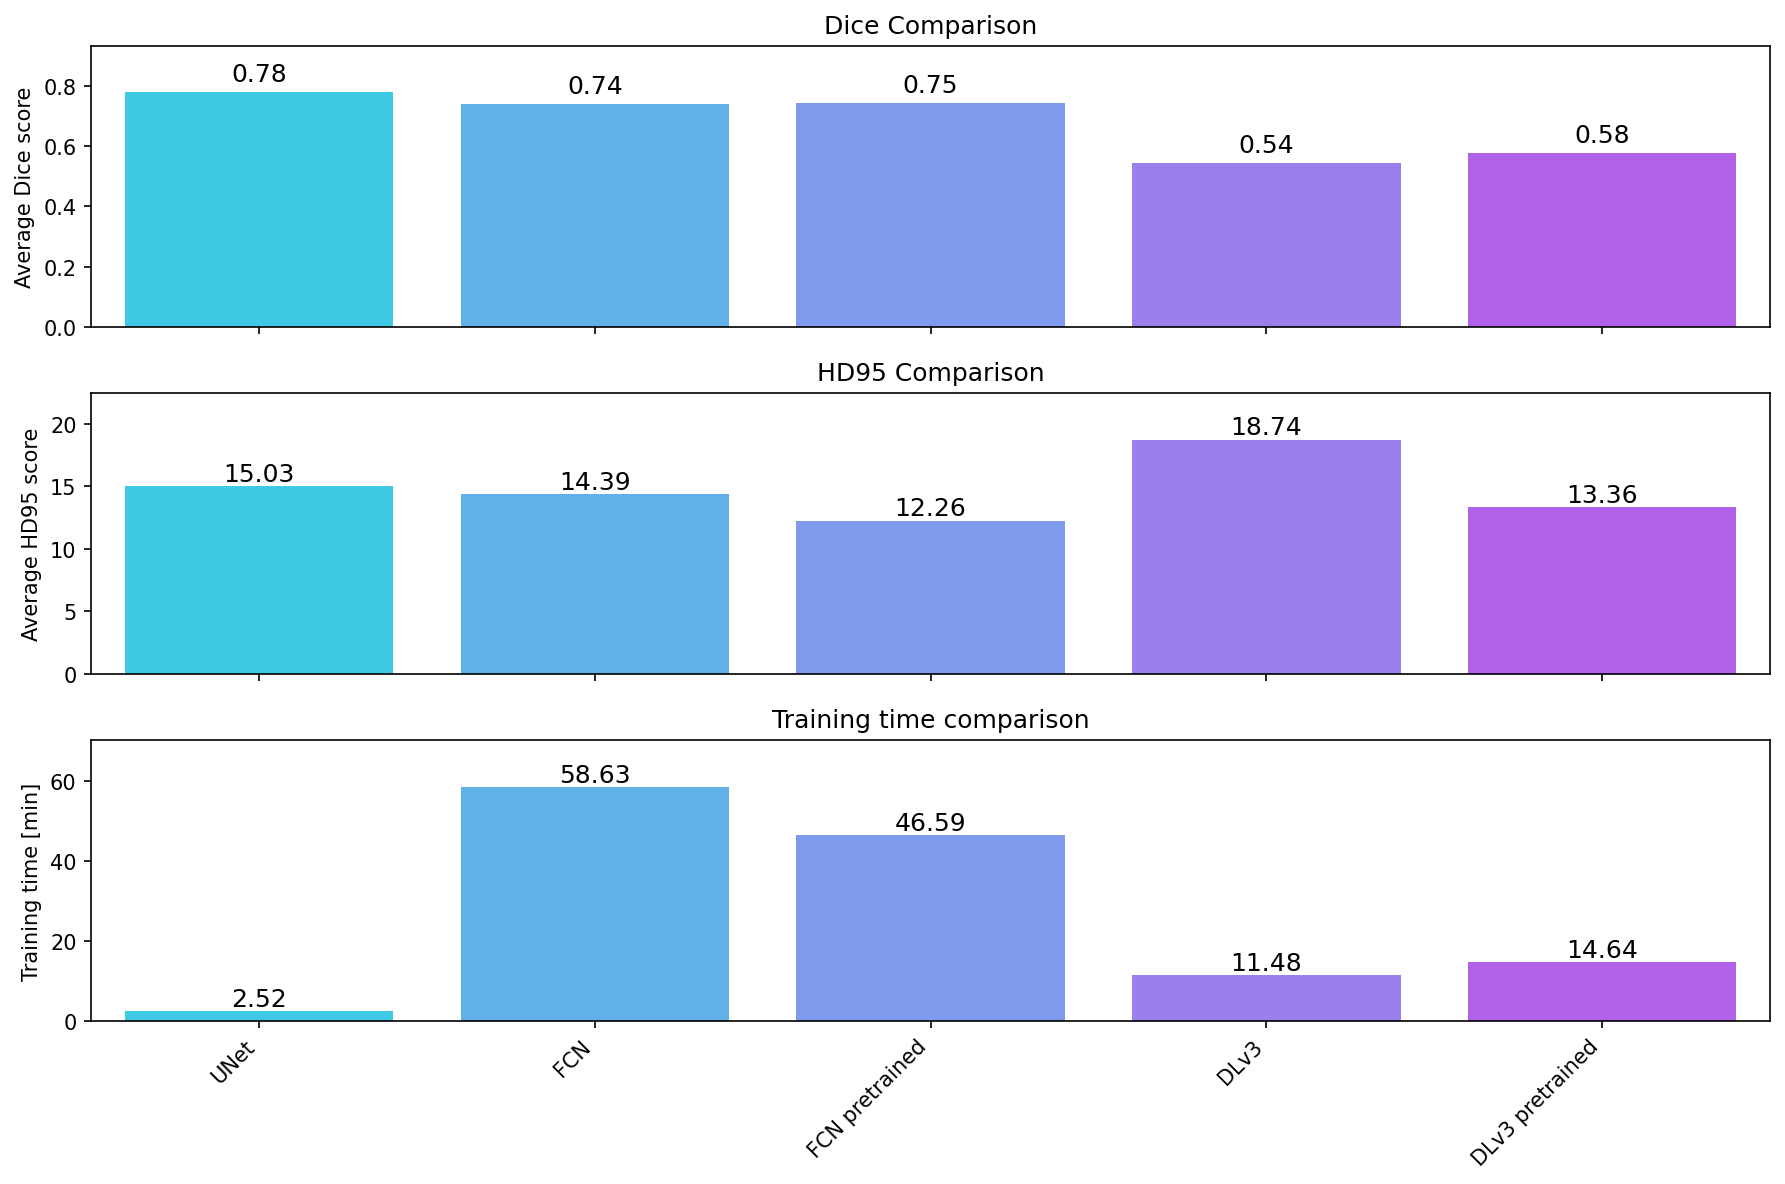

In [75]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), dpi=150)

subplot_bar(axes[0], model_names, dices_lst, "Dice Comparison", "Average Dice score")
subplot_bar(axes[1], model_names, hd95_lst, "HD95 Comparison", "Average HD95 score")
subplot_bar(axes[2], model_names, models_time_lst, "Training time comparison", "Training time [min]", show_names=True)

plt.tight_layout()
plt.show()

**Results overview**

---

 **UNet**
* Loss curves: Stable convergence, smooth decrease of training and validation losses with minimal gap. No clear overfitting.  
* Metrics:  
  * Highest Dice score (0.78),  
  * Competitive HD95 (15.03),  
  * Extremely fast training (2.52 min).  
* Conclusion: The best balance between segmentation quality, stability, and efficiency.  


**FCN (ResNet-50, no pretraining)**  
* Loss curves: Converges relatively quickly, but validation loss starts diverging after a few epochs (signs of overfitting).  
* Metrics:  
  * Dice 0.74, HD95 14.39 (slightly worse than UNet),  
  * Longest training time (58.63 min).  
* Conclusion: Acceptable results but inefficient in terms of training cost and prone to overfitting.  


**FCN pretrained (ResNet-50)**  
* Loss curves: More stable than the non-pretrained version, training/validation losses stay closer.  
* Metrics: 
  * Dice 0.75, best HD95 (12.26),  
  * Training time 46.59 min.  
* Conclusion: Pretraining improves robustness and boundary accuracy (HD95), but training time remains a bottleneck.  


**DeepLabV3 (MobileNetV3, no pretraining)**  
* Loss curves: Highly unstable, strong oscillations in validation loss → ineffective training.  
* Metrics:  
  * Lowest Dice (0.54) and worst HD95 (18.74),  
  * Training time 11.48 min (moderate).  
* Conclusion: Poor generalization, unsuitable for this task.  


**DeepLabV3 pretrained (MobileNetV3)**  
* Loss curves: Slightly more stable than the non-pretrained version, but still large fluctuations.  
* Metrics:  
  * Dice 0.58, HD95 13.36,  
  * Training time 14.64 min.  
* Conclusion: Pretraining helps, but performance remains below UNet and FCN.  


**Final Comparison**  
* Best overall model: **UNet** (highest Dice, fast training, stable learning).  
* Best boundary accuracy: **FCN pretrained** (lowest HD95).  
* Worst models: **DeepLabV3** (with and without pretraining) — unstable training and weak performance.  

In conclusion, UNet proves to be the most reliable and efficient model for this MRI segmentation task. FCN can be considered as a secondary choice when boundary precision is prioritized, but at the cost of longer training time. DeepLabV3 is not recommended for this dataset. However, **the overall results are not satisfactory** — further improvements in the training process or data preprocessing are necessary to achieve higher segmentation accuracy.  

**Ideas for improvement**
To further enhance the model performance, the following strategies should be considered:  
1. Removal of empty slices.  
2. Experimentation with different input image sizes (e.g., resizing or cropping) to find a better trade-off between spatial detail and computational efficiency.  
3. Extended hyperparameter optimization using Optuna (learning rate schedules, batch sizes, more trials).
4. Different backbones testing.  